## Neural network predicting 1 future point based on velocities

In [15]:
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

## Data preparation

In [33]:
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:08<00:00, 33.99it/s]


Warning! too big dt in [Edinburgh]
finish


In [40]:
train_agent_ids = np.load('Edinburgh_train_agent_ids.npy')
test_agent_ids = np.load('Edinburgh_test_agent_ids.npy')

### Helper functions

In [41]:
def create_dataset(data, agent_ids):
    data_X, data_Y_vel_x, data_Y_vel_y = [], [], []
    for agent_id in agent_ids:
        # We only see 4 velocities, so train is 4 velocities long
        x = data[data['agent_id'] == agent_id].iloc[1:5][['vel_x', 'vel_y']]
        y_vel_x = data[data['agent_id'] == agent_id].iloc[5]['vel_x']
        y_vel_y = data[data['agent_id'] == agent_id].iloc[5]['vel_y']
        data_X.append(x)
        data_Y_vel_x.append(y_vel_x)
        data_Y_vel_y.append(y_vel_y)
    return np.array(data_X), np.array(data_Y_vel_x), np.array(data_Y_vel_y)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [42]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [43]:
from keras.models import Model
from keras.layers import *    
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#inp = Input((5,2))
inp = Input((4,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [44]:
y_vel_x, y_vel_y = train[1], train[2] # separate the y data into x and y position columns
model.fit(train[0], [y_vel_x, y_vel_y], epochs=400, batch_size=32, verbose=2)
model.save('models/Edinburgh_NN_single_point_pred_velocity')

Epoch 1/400


2022-01-14 12:10:07.899431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 - 1s - loss: 0.7043 - dense_40_loss: 0.3402 - dense_41_loss: 0.3640 - 527ms/epoch - 11ms/step
Epoch 2/400
50/50 - 0s - loss: 0.5269 - dense_40_loss: 0.2596 - dense_41_loss: 0.2673 - 250ms/epoch - 5ms/step
Epoch 3/400
50/50 - 0s - loss: 0.4939 - dense_40_loss: 0.2421 - dense_41_loss: 0.2518 - 248ms/epoch - 5ms/step
Epoch 4/400
50/50 - 0s - loss: 0.4840 - dense_40_loss: 0.2320 - dense_41_loss: 0.2520 - 249ms/epoch - 5ms/step
Epoch 5/400
50/50 - 0s - loss: 0.4719 - dense_40_loss: 0.2268 - dense_41_loss: 0.2452 - 249ms/epoch - 5ms/step
Epoch 6/400
50/50 - 0s - loss: 0.4618 - dense_40_loss: 0.2200 - dense_41_loss: 0.2418 - 252ms/epoch - 5ms/step
Epoch 7/400
50/50 - 0s - loss: 0.4622 - dense_40_loss: 0.2212 - dense_41_loss: 0.2409 - 256ms/epoch - 5ms/step
Epoch 8/400
50/50 - 0s - loss: 0.4545 - dense_40_loss: 0.2137 - dense_41_loss: 0.2408 - 276ms/epoch - 6ms/step
Epoch 9/400
50/50 - 0s - loss: 0.4551 - dense_40_loss: 0.2154 - dense_41_loss: 0.2397 - 276ms/epoch - 6ms/step
Epoch 10/400

In [45]:
trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

2022-01-14 12:15:17.523306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train Score: 0.21
Test Score: 0.66


## Predicting on train data and plotting

2022-01-14 11:38:42.060961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


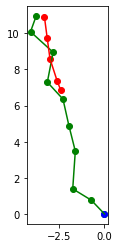

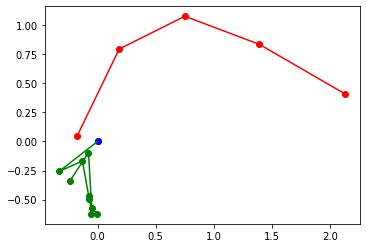

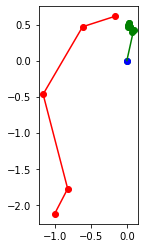

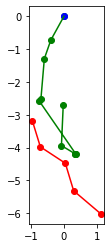

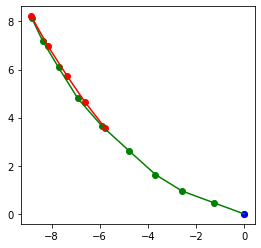

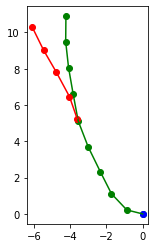

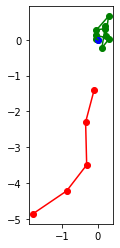

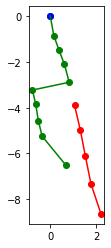

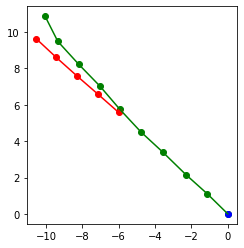

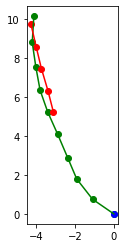

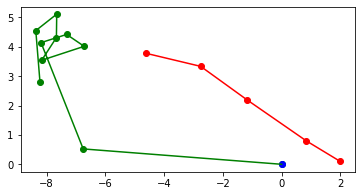

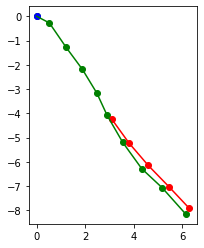

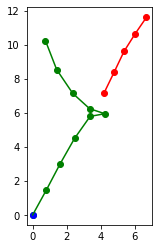

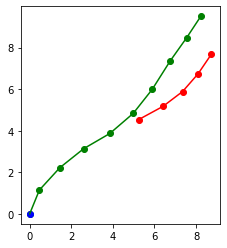

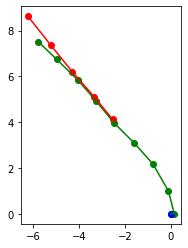

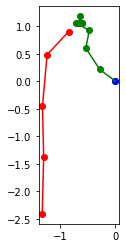

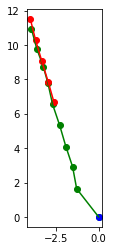

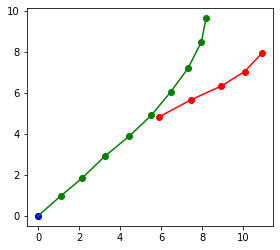

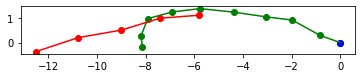

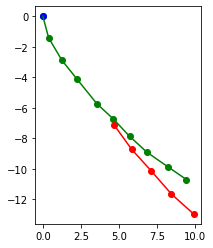

Average FDE:  2.624908479734029


In [27]:
# Creating a 'rolling' prediction, predicting 1 point based on 5 seen points, then another point based
# on 4 seen points and 1 predicted point and so on
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    rolling_vel_x = np.array(seen_vel_x)
    rolling_vel_y = np.array(seen_vel_y)
    for i in range(5):
        seen_velocities = np.column_stack((rolling_vel_x, rolling_vel_y))
        pred_vel_x, pred_vel_y = model.predict(np.array([seen_velocities]))

        # To get the fifth velocity we need for prediction
        if i == 4:
            rolling_vel_x = np.append(rolling_vel_x, [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y, [pred_vel_y[0]])
        else:
            rolling_vel_x = np.append(rolling_vel_x[1:], [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y[1:], [pred_vel_y[0]])

    # Create coordinates from the velocity predictions
    pred_coord_x = [seen_x[-1] + rolling_vel_x[0]]
    pred_coord_y = [seen_y[-1] + rolling_vel_y[0]]
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[i-1] + rolling_vel_x[i])
        pred_coord_y.append(pred_coord_y[i-1] + rolling_vel_y[i])
        
    # Calculate final displacement error
    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(pred_coord_x, pred_coord_y, color='r')
        plt.scatter(pred_coord_x, pred_coord_y, color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))